<b> Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.compose importmake_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import  SVC
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.pipeline import make_pipeline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)


C:\Users\Arpan\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<b> Loading datasets

In [8]:
training = pd.read_csv('train.csv')
train_data = training.copy()
test_data = pd.read_csv('test.csv')

In [9]:
train_data.head()

,Id,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Behaviour
0,1,30,0,Non-Travel,Research & Development,2,3,Medical,571,3,Female,3,Laboratory Technician,4,Single,2564,0,No,14,3,0,12,2,11,7,6,7,4,1
1,2,36,0,Travel_Rarely,Research & Development,12,4,Life Sciences,1614,3,Female,3,Manufacturing Director,3,Married,4663,9,Yes,12,3,2,7,2,3,2,1,1,2,1
2,3,55,1,Travel_Rarely,Sales,2,1,Medical,842,3,Male,3,Sales Executive,4,Single,5160,4,No,16,3,0,12,3,9,7,7,3,5,1
3,4,39,0,Travel_Rarely,Research & Development,24,1,Life Sciences,2014,1,Male,3,Research Scientist,4,Single,4108,7,No,13,3,0,18,2,7,7,1,7,4,1
4,5,37,0,Travel_Rarely,Research & Development,3,3,Other,689,3,Male,3,Manufacturing Director,3,Married,9434,1,No,15,3,1,10,2,10,7,7,8,1,1


In [5]:
print('Observations: ',train_data.shape[0])
print('Features: ',train_data.shape[1])

Observations:  1628
Features:  29


Dropping Id and Behaviour (Behaviour has only 1 value)

In [10]:
train_id = train_data.Id
train_data = train_data.drop(['Behaviour','Id'],axis = 1)

test_id = test_data.Id
test_data = test_data.drop(['Behaviour','Id'],axis = 1)

Basic Cleaning

In [11]:
train_data['PerformanceRating'] = train_data['PerformanceRating'].apply(lambda x: 0 if x == 3 else 1)
test_data['PerformanceRating'] = test_data['PerformanceRating'].apply(lambda x: 0 if x == 3 else 1)

Checking for duplicates

In [14]:
print('Number of duplicates: ',train_data.duplicated().sum())

Number of duplicates:  628


In [15]:
# drop them

train_unq = train_data.drop_duplicates()
print('New train set: ',train_unq.shape)
X = train_unq.drop('Attrition',axis = 1)
y = train_unq['Attrition']

New train set:  (1000, 27)


Creating a Pipeline for training and validation<br>

- Dropped performance rating as 85% values are 1
- OHE on all the object dtype columns
- Standard scaling on the rest

In [16]:
# Standard Scaling
skf = StratifiedKFold(n_splits = 10,random_state=42,shuffle=True)

categorical = [f for f in training.columns if training[f].dtype == object]
numeric = [f for f in X.columns if f not in categorical+['Id','Attrition','Behaviour','PerformanceRating']]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))

Testing on 3 candidate models: Random Forest, XGBoost, Support Vector Machines

In [17]:
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier())
pipe_svc = make_pipeline(pre_pipe,SVC(probability=True))


print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='roc_auc')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='roc_auc')))
print('SVC:',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

RF:  0.7995393907563025
XGB:  0.7940574229691877
SVC: 0.822673319327731


SVC performs best here - trying out PCA

SVC:  0.8192405462184873


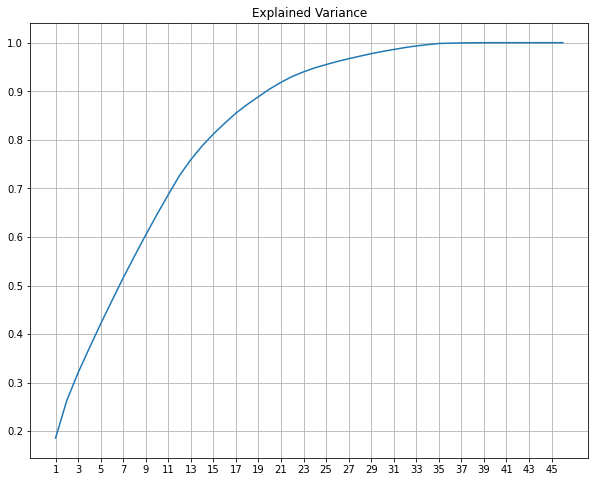

In [20]:
n = 46
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

plt.figure(figsize=(10,8))
pipe_svc.fit(X,y)
plt.plot(range(1,n+1),pipe_svc.named_steps['pca'].explained_variance_ratio_.cumsum())
plt.xticks(range(1,n+1,2))
plt.title('Explained Variance')
plt.grid()
plt.show()

34 components are explaining 100% of the variance

In [21]:
n = 34
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric),remainder = 'passthrough')
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

SVC:  0.8196367296918767


Tuning SVC - using Grid Search

In [22]:
n = 34
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric),remainder = 'passthrough')
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf'))

param_grid = {
    
    'svc__C':[0.001,0.01,0.1,1,10,100,1000],
    'svc__gamma': ['auto','scale'],
    'svc__class_weight': ['balanced',None]
}

grid_search = GridSearchCV(pipe_svc,param_grid=param_grid,cv = skf, verbose=2, n_jobs = -1,scoring='roc_auc')
grid_search.fit(X,y)
print('Best score ',grid_search.best_score_)
print('Best parameters ',grid_search.best_params_)
best_svc = grid_search.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.5s


Best score  0.8317690826330532
Best parameters  {'svc__C': 0.1, 'svc__class_weight': None, 'svc__gamma': 'auto'}


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   10.2s finished


In [24]:
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf',class_weight=None,gamma='auto'))
param_grid={
    'svc__C':[0.01,0.03,0.05,0.07,0.1,0.3,0.5,0.7,1]  
}
grid_search = GridSearchCV(pipe_svc,param_grid=param_grid,cv = skf, verbose=2, n_jobs = -1,scoring = 'roc_auc')
grid_search.fit(X,y)
print('Best score ',grid_search.best_score_)
print('Best parameters ',grid_search.best_params_)
best_svc = grid_search.best_estimator_ # final model - 0.808 private LB*

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s


Best score  0.8319178921568628
Best parameters  {'svc__C': 0.05}


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.5s finished
